### <center><font color=navy> Tutorial #11 Computer- and robot-assisted surgery</font></center>
## <center><font color=navy> ML Basics III/Workflow</font></center>
<center>&copy; Sebastian Bodenstedt, National Center for Tumor Diseases (NCT) Dresden<br>
    <a href="https://www.nct-dresden.de/"><img src="https://www.nct-dresden.de/++theme++nct/images/logo-nct-en.svg"></a> </center>

## <center><font color=navy>Preperation</font></center>

For this tutorial, we will utilize the OpenCV, Matplotlib and NumPy:

In [1]:
import cv2
import numpy as np
# Force Matplotlib to display data directly in Jupyter
%matplotlib inline
from matplotlib import pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

We will also download some data:

## <center><font color=navy>Neural network vs LSTM for forecasting</font></center>

Import dataset

In [ ]:
data_train_orig = np.loadtxt("Exercises/Exercise11/DailyDelhiClimateTrain.csv", delimiter=",", skiprows=1, usecols = (1,2,3,4)).astype(np.float32)
data_test_orig = np.loadtxt("Exercises/Exercise11/DailyDelhiClimateTest.csv", delimiter=",", skiprows=1, usecols = (1,2,3,4)).astype(np.float32)

print(data_train_orig.shape)
print(data_test_orig.shape)

(1462, 4)
(114, 4)


Visualize training data

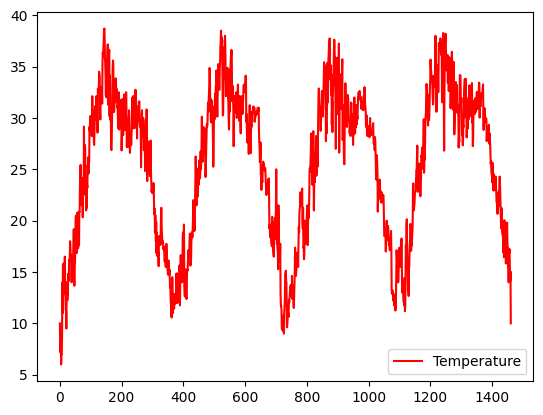

In [6]:
plt.plot(data_train_orig[:, 0], label="Temperature", color='red')
plt.legend()

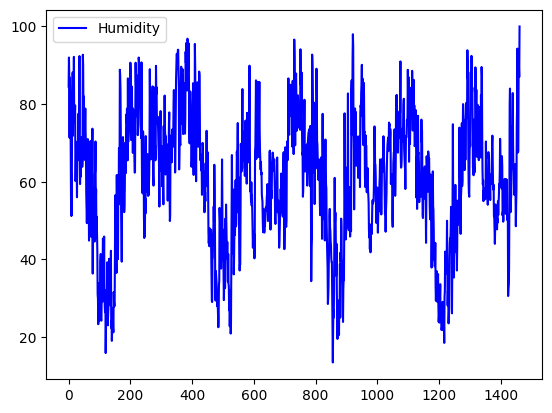

In [7]:
plt.plot(data_train_orig[:, 1], label="Humidity", color='blue')
plt.legend()

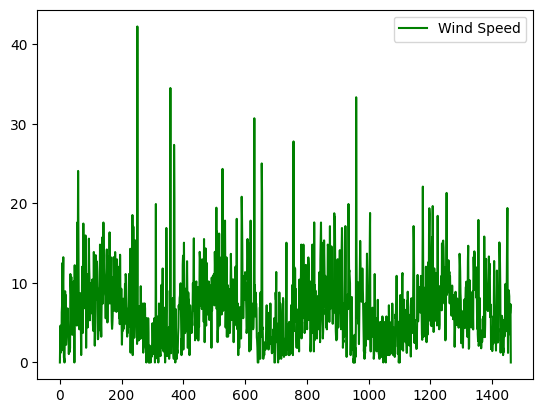

In [8]:
plt.plot(data_train_orig[:, 2], label="Wind Speed", color='green')
plt.legend()

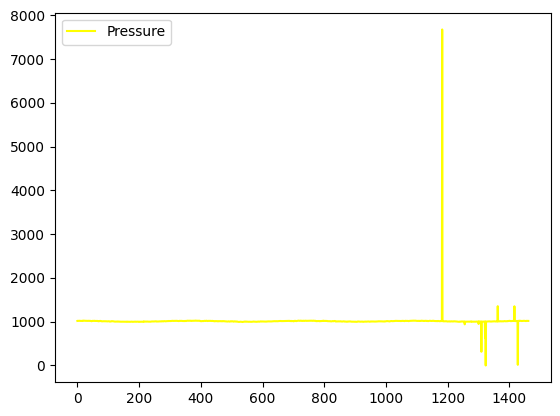

In [9]:
plt.plot(data_train_orig[:, 3], label="Pressure", color='yellow')
plt.legend()

Let's first normalize the training data based on the mean and std of the training data:

In [10]:
mean = np.mean(data_train_orig, axis=0)
std = np.std(data_train_orig, axis=0)

print(mean)
print(std)

data_train = data_train_orig - mean
data_train /=std

print(np.mean(data_train, axis=0))
print(np.std(data_train, axis=0))

[  25.495522   60.771732    6.802209 1011.10516 ]
[  7.3455834  16.763922    4.5600414 180.17007  ]
[-1.2785237e-07 -1.8602194e-06 -2.0384626e-08 -3.4133150e-06]
[1.0000004  0.99999976 1.0000004  0.9999996 ]


Let's also normalize the testdata:

In [11]:
data_test = data_test_orig - mean
data_test /=std

print(np.mean(data_test, axis=0))
print(np.std(data_test, axis=0))

[-0.5149276  -0.26923114  0.29423305 -0.03924111]
[0.8620303  1.1324478  0.78338706 0.4944294 ]


Since we want to predict the weather on the next day, let's divide the dataset into input and output:

In [12]:
x_train = data_train[:-1]
y_train = data_train[1:]

x_test = data_test[:-1]
y_test = data_test[1:]

Now, let's construct a simple neural network to predict the next samples:

In [13]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__() # Call constructur of parent class

        self.fc1 = nn.Linear(4, 10) # Create a fully-connected (linear) input layer with 4 inputs and 10 outputs
        self.fc2 = nn.Linear(10, 10) # Create a fully-connected (linear) hidden layer with 10 inputs and 10 outputs
        self.fc3 = nn.Linear(10, 4) # Create a fully-connected (linear) output layer with 10 inputs and 4 output

    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)

        x = self.fc2(x)
        x = torch.sigmoid(x)

        x = self.fc3(x)
        return x

We divide the dataset in so-called "Batches". We perform the back-propagation step and the gradient descent step for each batch separately, reducing the memory footprint and speeding up calculation.

In [14]:
batch_size = 50

num_train_batches = math.ceil(x_train.shape[0]/batch_size)
num_test_batches = 1

x_train_batches = np.array_split(x_train, num_train_batches, 0)
y_train_batches = np.array_split(y_train, num_train_batches, 0)

x_test_batches = np.array_split(x_test, num_test_batches, 0)
y_test_batches = np.array_split(y_test, num_test_batches, 0)

Furthermore, we need to define a cost function. As we are performing regression, we will utilize either L1 or L2 norm:

In [15]:
criterion = nn.L1Loss()
#criterion = nn.MSELoss()

We also have to decide whether we could like to use the GPU or the CPU:

In [16]:
use_gpu = True

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

print(device)

cpu


We also initialize our model:

In [17]:
model = Network()
model = model.to(device)

Next, we define the optimizer. The optimizer performs the gradient step for us. Here, we utilize so-called "Stochastic Gradient Descent". We also have to specify the step size for gradient descent, the so-called learning rate:

In [18]:
learning_rate = 5e-2

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

We then define a training function, which iterates through all batches, converts the data into pytorch data types, puts the data through the network and finally performs the backpropagation and gradient descent.

In [19]:
def training_step(model, x, y, loss, optimizer):
    model.train()

    losses = []

    for i in range(len(x)):
        optimizer.zero_grad()

        x_tensor = torch.from_numpy(x[i]).to(device)
        y_tensor = torch.from_numpy(y[i]).to(device)

        output = model(x_tensor)

        loss = criterion(output, y_tensor)

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)

We also define a validation function that we can use to simply test the model on data, without modifying the model

In [20]:
def validation_step(model, x, y, loss):
    model.eval()
    losses = []

    with torch.no_grad():
        for i in range(len(x)):
            x_tensor = torch.from_numpy(x[i]).to(device)
            y_tensor = torch.from_numpy(y[i]).to(device)

            output = model(x_tensor)

            loss = criterion(output, y_tensor)

            losses.append(loss.item())

    return np.mean(losses)

Let's see how an untrained model performs:

In [21]:
train_loss = validation_step(model, x_train_batches, y_train_batches, criterion)
val_loss = validation_step(model, x_test_batches, y_test_batches, criterion)

print("Error before training: train loss %.03f validation loss %.03f accuracy" % (train_loss, val_loss))

Error before training: train loss 0.688 validation loss 0.636 accuracy


Now, we try to train the model for a couple of iterations (so called epochs):

In [22]:
num_epochs = 1000

for e in range(num_epochs):
    train_loss = training_step(model, x_train_batches, y_train_batches, criterion, optimizer)
    val_loss = validation_step(model, x_test_batches, y_test_batches, criterion)
    if e % 100 == 0:
        print("Epoch %d: train loss %.03f validation loss %.03f" % (e + 1, train_loss, val_loss))

Epoch 1: train loss 0.651 validation loss 0.627
Epoch 101: train loss 0.315 validation loss 0.341
Epoch 201: train loss 0.310 validation loss 0.308
Epoch 301: train loss 0.310 validation loss 0.296
Epoch 401: train loss 0.313 validation loss 0.313
Epoch 501: train loss 0.317 validation loss 0.307
Epoch 601: train loss 0.322 validation loss 0.318
Epoch 701: train loss 0.329 validation loss 0.301
Epoch 801: train loss 0.308 validation loss 0.316
Epoch 901: train loss 0.321 validation loss 0.333


Let's visualize the difference between the prediction and groundtruth

In [23]:
with torch.no_grad():
    x_tensor = torch.from_numpy(x_test_batches[0]).to(device)

    output = model(x_tensor)
    output = output.squeeze(1).cpu()

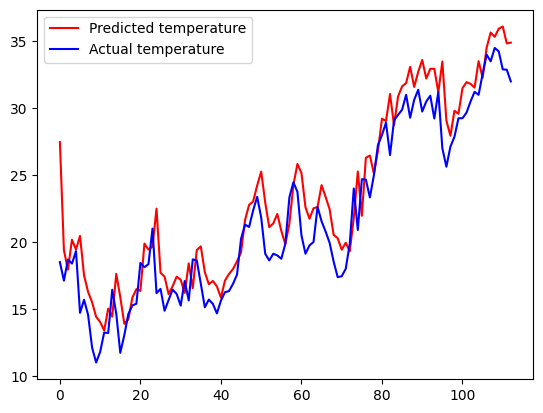

In [24]:
plt.plot(output[:, 0]*std[0]+mean[0], label="Predicted temperature", color='red')
plt.plot(y_test_batches[0][:, 0]*std[0]+mean[0], label="Actual temperature", color='blue')
plt.legend()

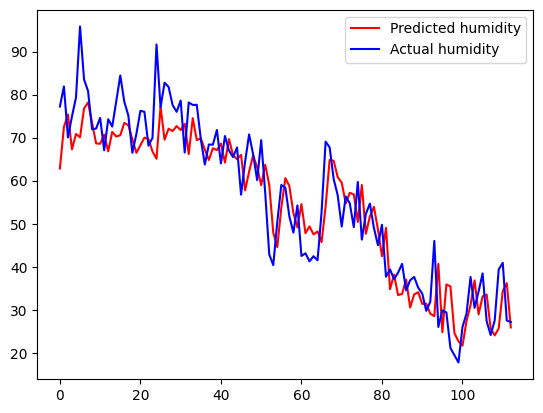

In [25]:
plt.plot(output[:, 1]*std[1]+mean[1], label="Predicted humidity", color='red')
plt.plot(y_test_batches[0][:, 1]*std[1]+mean[1], label="Actual humidity", color='blue')
plt.legend()

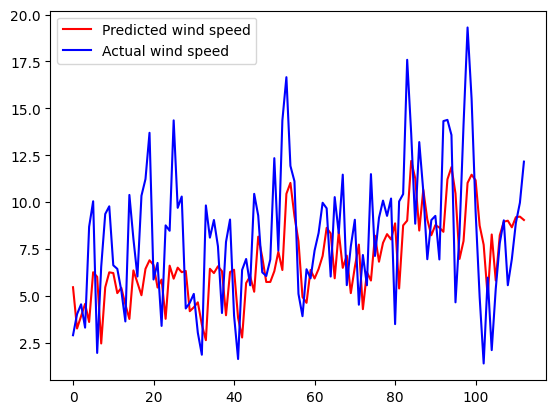

In [26]:
plt.plot(output[:, 2]*std[2]+mean[2], label="Predicted wind speed", color='red')
plt.plot(y_test_batches[0][:, 2]*std[2]+mean[2], label="Actual wind speed", color='blue')
plt.legend()

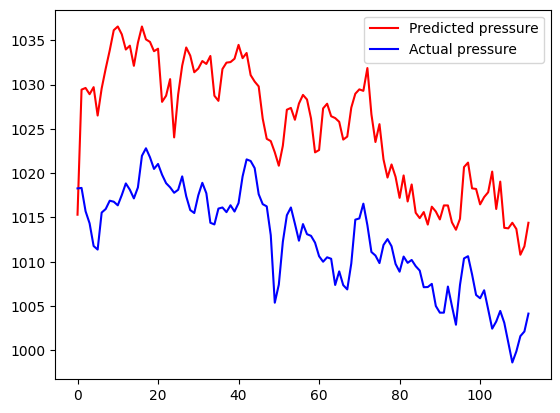

In [27]:
plt.plot(output[:, 3]*std[3]+mean[3], label="Predicted pressure", color='red')
plt.plot(y_test_batches[0][:, 3]*std[3]+mean[3], label="Actual pressure", color='blue')
plt.legend()

But what if we only know the first value? Can we predict the trend of the curve?

In [28]:
outputs = np.zeros_like(x_test_batches[0])
cur_val = torch.from_numpy(x_test_batches[0][0]).to(device).unsqueeze(0)

for i in range(x_test_batches[0].shape[0]):
  with torch.no_grad():
      cur_val = model(cur_val)
      outputs[i] = cur_val.squeeze(1).cpu().numpy()

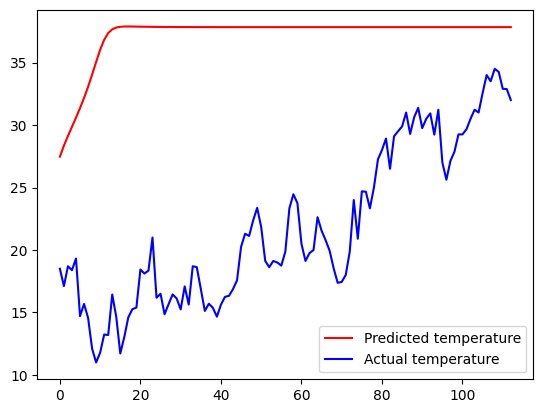

In [29]:
plt.plot(outputs[:, 0]*std[0]+mean[0], label="Predicted temperature", color='red')
plt.plot(y_test_batches[0][:, 0]*std[0]+mean[0], label="Actual temperature", color='blue')
plt.legend()

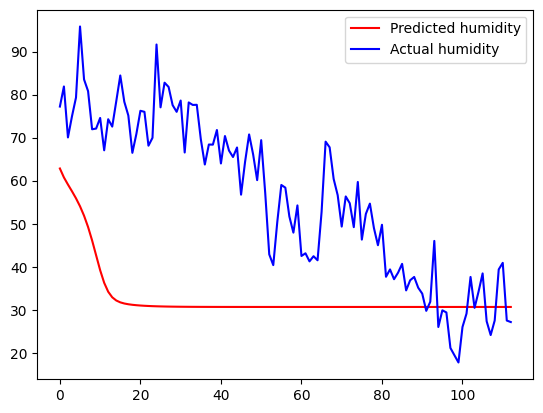

In [30]:
plt.plot(outputs[:, 1]*std[1]+mean[1], label="Predicted humidity", color='red')
plt.plot(y_test_batches[0][:, 1]*std[1]+mean[1], label="Actual humidity", color='blue')
plt.legend()

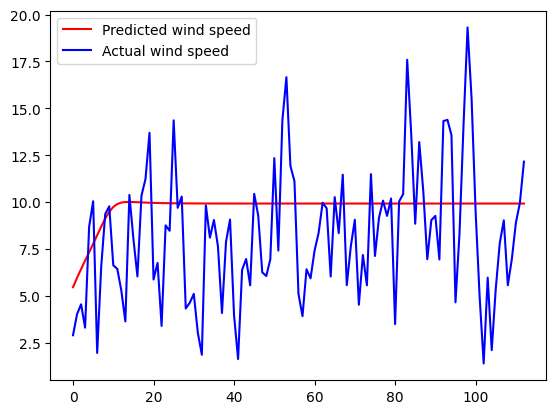

In [31]:
plt.plot(outputs[:, 2]*std[2]+mean[2], label="Predicted wind speed", color='red')
plt.plot(y_test_batches[0][:, 2]*std[2]+mean[2], label="Actual wind speed", color='blue')
plt.legend()

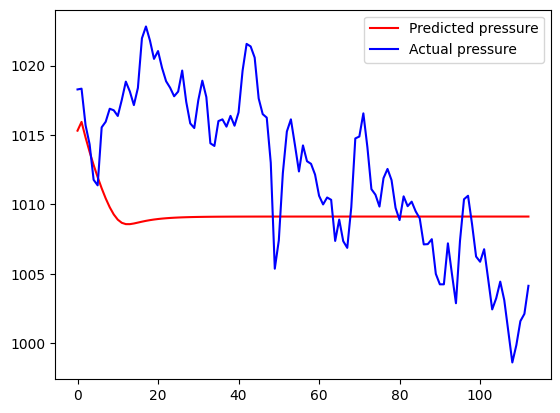

In [32]:
plt.plot(outputs[:, 3]*std[3]+mean[3], label="Predicted pressure", color='red')
plt.plot(y_test_batches[0][:, 3]*std[3]+mean[3], label="Actual pressure", color='blue')
plt.legend()

In [33]:
class Network_LSTM(nn.Module):
    def __init__(self):
        super(Network_LSTM, self).__init__() # Call constructur of parent class
        self.lstm = nn.LSTM(4, 10, 1, batch_first=True)
        self.fc = nn.Linear(10, 4)

    def forward(self, x, h=None):
        x = x.unsqueeze(0)
        x, h = self.lstm(x, h)

        x = x.squeeze(0)

        x = self.fc(x)

        return x, h

In [34]:
def training_step_lstm(model, x, y, loss, optimizer):
    model.train()

    losses = []
    hiddenstate = None
    for i in range(len(x)):
        optimizer.zero_grad()

        x_tensor = torch.from_numpy(x[i]).to(device)
        y_tensor = torch.from_numpy(y[i]).to(device)

        output, hiddenstate = model(x_tensor, hiddenstate)

        loss = criterion(output, y_tensor)

        loss.backward()

        optimizer.step()

        hiddenstate = (hiddenstate[0].detach(), hiddenstate[1].detach())

        losses.append(loss.item())

    return np.mean(losses)

def validation_step_lstm(model, x, y, loss):
    model.eval()
    losses = []

    with torch.no_grad():
        for i in range(len(x)):
            x_tensor = torch.from_numpy(x[i]).to(device)
            y_tensor = torch.from_numpy(y[i]).to(device)

            output, hiddenstate = model(x_tensor)

            loss = criterion(output, y_tensor)

            losses.append(loss.item())

    return np.mean(losses)

In [35]:
model_lstm = Network_LSTM()
model_lstm = model_lstm.to(device)

learning_rate = 5e-4

optimizer = optim.AdamW(model_lstm.parameters(), lr=learning_rate)

In [36]:
num_epochs = 1000

for e in range(num_epochs):
    train_loss = training_step_lstm(model_lstm, x_train_batches, y_train_batches, criterion, optimizer)
    val_loss = validation_step_lstm(model_lstm, x_test_batches, y_test_batches, criterion)
    if e % 100 == 0:
        print("Epoch %d: train loss %.03f validation loss %.03f" % (e + 1, train_loss, val_loss))

Epoch 1: train loss 0.726 validation loss 0.755
Epoch 101: train loss 0.298 validation loss 0.291
Epoch 201: train loss 0.286 validation loss 0.279
Epoch 301: train loss 0.281 validation loss 0.272
Epoch 401: train loss 0.277 validation loss 0.271
Epoch 501: train loss 0.274 validation loss 0.272
Epoch 601: train loss 0.272 validation loss 0.271
Epoch 701: train loss 0.271 validation loss 0.269
Epoch 801: train loss 0.270 validation loss 0.268
Epoch 901: train loss 0.269 validation loss 0.269


Let's visualize the results again

In [37]:
with torch.no_grad():
    x_tensor = torch.from_numpy(x_test_batches[0]).to(device)

    output, _ = model_lstm(x_tensor)
    output = output.squeeze(1).cpu()

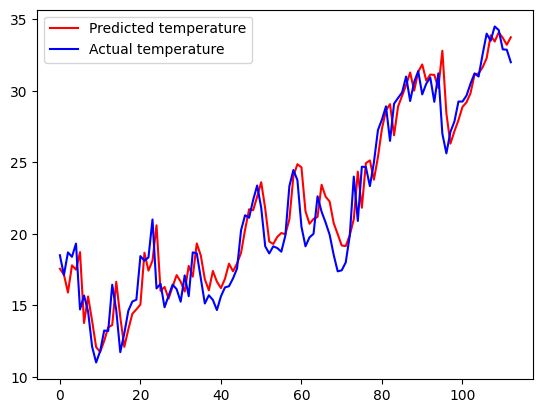

In [38]:
plt.plot(output[:, 0]*std[0]+mean[0], label="Predicted temperature", color='red')
plt.plot(y_test_batches[0][:, 0]*std[0]+mean[0], label="Actual temperature", color='blue')
plt.legend()

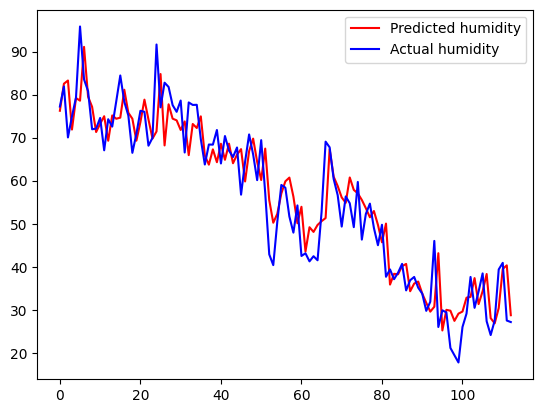

In [39]:
plt.plot(output[:, 1]*std[1]+mean[1], label="Predicted humidity", color='red')
plt.plot(y_test_batches[0][:, 1]*std[1]+mean[1], label="Actual humidity", color='blue')
plt.legend()

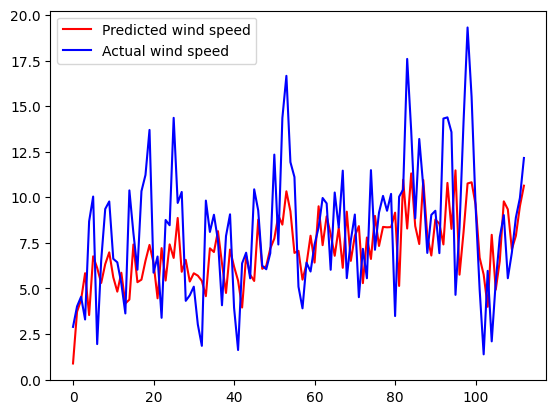

In [40]:
plt.plot(output[:, 2]*std[2]+mean[2], label="Predicted wind speed", color='red')
plt.plot(y_test_batches[0][:, 2]*std[2]+mean[2], label="Actual wind speed", color='blue')
plt.legend()

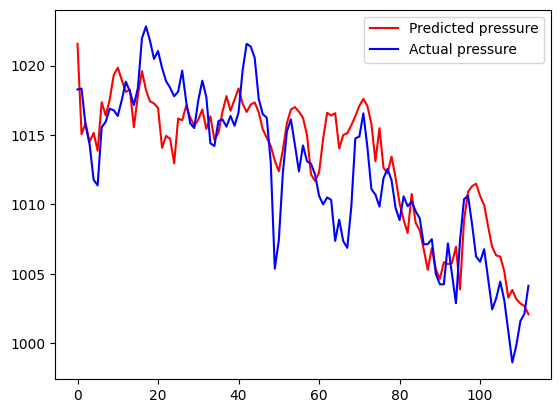

In [41]:
plt.plot(output[:, 3]*std[3]+mean[3], label="Predicted pressure", color='red')
plt.plot(y_test_batches[0][:, 3]*std[3]+mean[3], label="Actual pressure", color='blue')
plt.legend()

But what if we only know the first value? Can we predict the trend of the curve better with an LSTM?

In [42]:
outputs = np.zeros_like(x_test_batches[0])
cur_val = torch.from_numpy(x_test_batches[0][0]).to(device).unsqueeze(0)
hiddenstate = None

for i in range(x_test_batches[0].shape[0]):
  with torch.no_grad():
      cur_val, hiddenstate = model_lstm(cur_val, hiddenstate)
      outputs[i] = cur_val.squeeze(1).cpu().numpy()

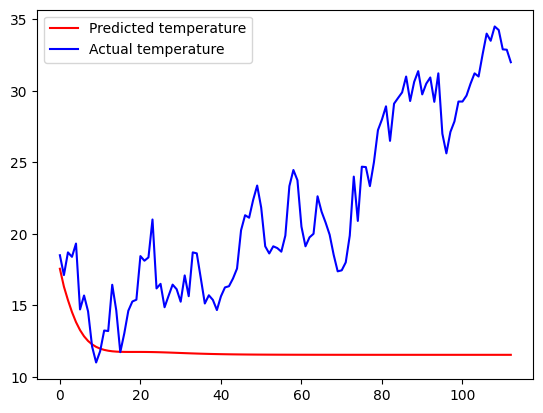

In [43]:
plt.plot(outputs[:, 0]*std[0]+mean[0], label="Predicted temperature", color='red')
plt.plot(y_test_batches[0][:, 0]*std[0]+mean[0], label="Actual temperature", color='blue')
plt.legend()

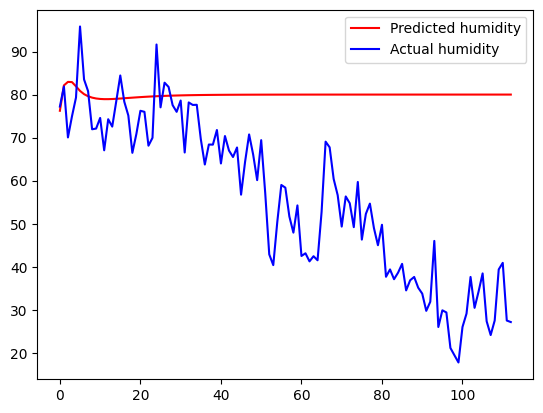

In [44]:
plt.plot(outputs[:, 1]*std[1]+mean[1], label="Predicted humidity", color='red')
plt.plot(y_test_batches[0][:, 1]*std[1]+mean[1], label="Actual humidity", color='blue')
plt.legend()

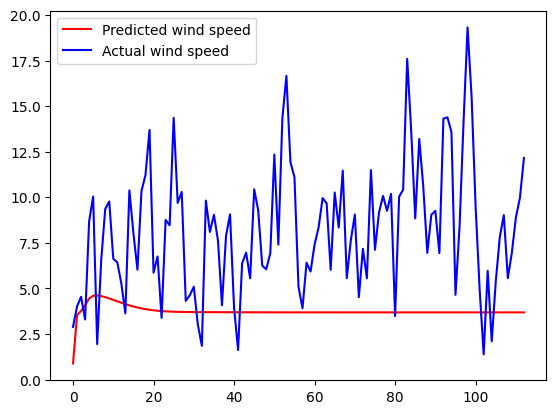

In [45]:
plt.plot(outputs[:, 2]*std[2]+mean[2], label="Predicted wind speed", color='red')
plt.plot(y_test_batches[0][:, 2]*std[2]+mean[2], label="Actual wind speed", color='blue')
plt.legend()

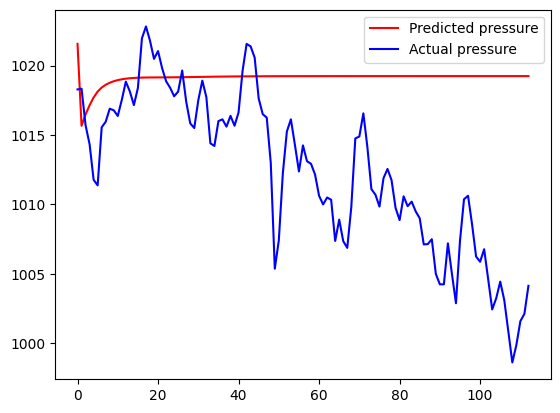

In [46]:
plt.plot(outputs[:, 3]*std[3]+mean[3], label="Predicted pressure", color='red')
plt.plot(y_test_batches[0][:, 3]*std[3]+mean[3], label="Actual pressure", color='blue')
plt.legend()

## <center><font color=navy>Continue sequence</font></center>

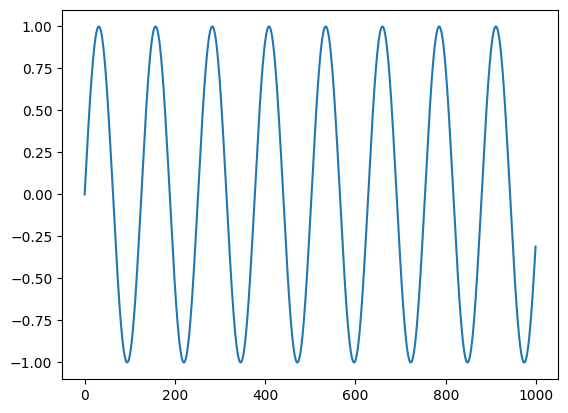

In [47]:
T = 20
N = 1000

x = np.arange(N)
data = np.sin(x / 1.0 / T).astype('float32')

plt.plot(data)

In [48]:
batch_size = 50

x_train = np.expand_dims(data[:-1], axis=1)
y_train = np.expand_dims(data[1:], axis=1)

num_train_batches = math.ceil(x_train.shape[0]/batch_size)

x_train_batches = np.array_split(x_train, num_train_batches, 0)
y_train_batches = np.array_split(y_train, num_train_batches, 0)

In [49]:
class Network_LSTM_Curve(nn.Module):
    def __init__(self):
        super(Network_LSTM_Curve, self).__init__() # Call constructur of parent class
        # TODO: write own model

    def forward(self, x, h=None):
        #TODO implement data processing

        return x, h

In [ ]:
model_lstm_curve = Network_LSTM_Curve()
model_lstm_curve = model_lstm_curve.to(device)

learning_rate = 5e-3 # try different learning rates

optimizer = optim.AdamW(model_lstm_curve.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 1000 #might need to adjust number of epochs

for e in range(num_epochs):
    train_loss = training_step_lstm(model_lstm_curve, x_train_batches, y_train_batches, criterion, optimizer)

    if e % 100 == 0:
        print("Epoch %d: train loss %.03f" % (e + 1, train_loss))

Does it perform well on sequence data?

In [ ]:
outputs = np.zeros_like(x_train)
cur_val = torch.from_numpy(x_train[0]).to(device).unsqueeze(0)
hiddenstate = None

for i in range(x_train.shape[0]):
  with torch.no_grad():
      cur_val, hiddenstate = model_lstm_curve(cur_val, hiddenstate)
      outputs[i] = cur_val.squeeze(1).cpu().numpy()

In [ ]:
plt.plot(outputs)